Example of gel trap image anlaysis using python tools available in Sci-kit image.

The purpose of this segment of code is to recognize particles in an image, and then count and measure them.

This code is specific for oblique lighting.  Identifying particles in oblique images is a little more difficult than brightfield lighting because particles range from very bright to very dark color intensities, whereas the background is at an intermediate intensity.  This makes medium intensity colors, like light brown, difficult to distinguish from the background after is is converted to greyscale.  To address this problem, the intermediate color pixels are analyzed in parallel with the greyscale image, and then all identified pixels of the particle in both analyses are combined to identify the complete particle area.  Intermediate pixels intensities are enhanced by subtracting the blue color channel from the red color channel.  Although the processing time of oblique images is longer than brightfield images, the translucent particles can be detected (which may especially affect smaller particles), and visual characteristics of particles are better represented.  A drawback of oblique lighting is that the exposure time on the camera needs to be longer because less light is reaching the camera- this leads to slightly more blurry images on a rolling ship (edges of particles aren't as sharp).

These particles were imaged in a polyacylamide gel sediment trap layer at multiple, increasing magnifications.  At higher magnifications, not all particles can be imaged in a single focal plane.  To image all particles, multiple images of the same field are captured at different focal planes, while attempting to ensure the the same particle is not in-focus across multiple focal planes.  For this reason, only particles defined as in-focus are counted in this analysis.  To ensure that all particles are detected, the threshold for what is defined as in-focus is fairly low.  Some out-of-focus particles are counted, and therefore counted multiple times across the focal planes of a single field of view.  These duplicate particle counts are filtered out in the de-duplication step.  Here, we want to detect as many particles as possible with atleast a first-cut filter to eliminate the most out-of-focus particles and noise.

## Step one: import the image and a blank sample image, subtract the background.

<IPython.core.display.Javascript object>


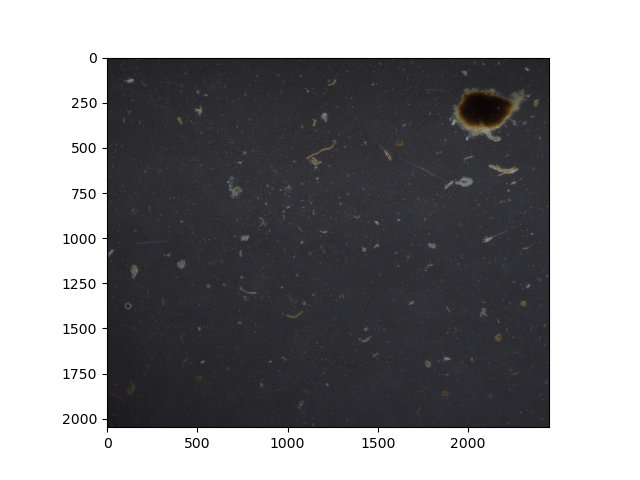

In [1]:
%matplotlib notebook
import numpy as np
from skimage import io, filters, color, measure, util, morphology, exposure
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage.filters import sobel
import math
import pandas as pd

photo = io.imread('/Users/colleen/Projects/EXPORTS/exports_images/Gels/RR53/RR53_obl/RR53_7x_obl/RR53_7x_obl_1.tiff',plugin='pil')
photo_blank = io.imread('/Users/colleen/Projects/EXPORTS/exports_images/Gels/RR65/RR65_obl/RR65_7x_obl/RR65_7x_obl_1.tiff', plugin= 'pil')
plt.imshow(photo)

Convert the image to greyscale, which is in luminescence units (0-1), this function uses equation Y = 0.2125 R + 0.7154 G + 0.0721 B.
Need to perform next operations on an 8-bit image, so convert to ubyte.
Also convert red and blue color channels to 8-bit greyscale images.

<IPython.core.display.Javascript object>


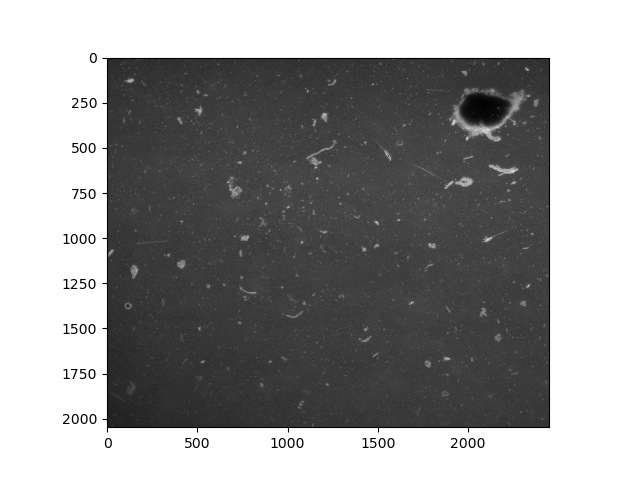

<IPython.core.display.Javascript object>


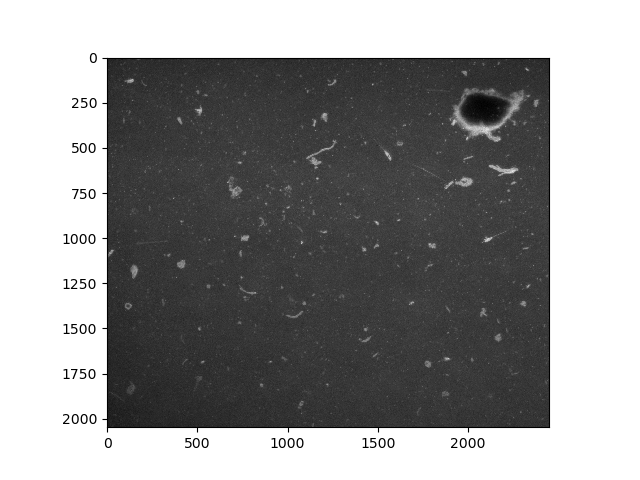

<IPython.core.display.Javascript object>


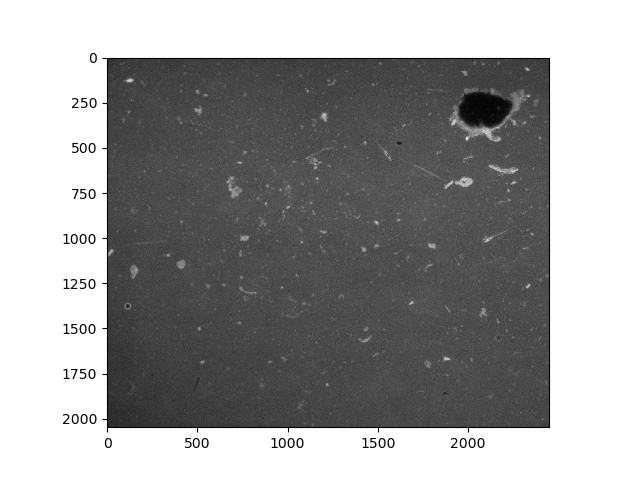

In [5]:
photo_grey1 = color.rgb2grey(photo)
photo_grey=util.img_as_ubyte(photo_grey1)
plt.figure()
plt.imshow(photo_grey,cmap=plt.cm.gray)
photo_red1 = photo[:,:,0]
photo_red=util.img_as_ubyte(photo_red1)
plt.figure()
plt.imshow(photo_red,cmap=plt.cm.gray)
photo_blue1 = photo[:,:,2]
photo_blue=util.img_as_ubyte(photo_blue1)
plt.figure()
plt.imshow(photo_blue,cmap=plt.cm.gray)

photo_blank_grey1 = color.rgb2grey(photo_blank)
photo_blank_grey=util.img_as_ubyte(photo_blank_grey1)
photo_blank_red1 = photo_blank[:,:,0]
photo_blank_red=util.img_as_ubyte(photo_blank_red1)
photo_blank_blue1 = photo_blank[:,:,2]
photo_blank_blue=util.img_as_ubyte(photo_blank_blue1)


## Background subtraction

Need to subtract uneven illumination from the background.  This will be normalized to the median value of the blank sample image.  The same background normalization steps are performed on the greyscale, red-channel, and blue-channel images.

Perform a median filter convolution of pixels across the image to determine regional (background) median pixel intensities.  The disk size over which the convolution is performed needs to be larger than the any possible particle size.  This will change depending on the magnification.

Subtract the median pixel value of the blank image from the median-filtered image.  The pixel values in the "photo_median_diff" image represent the changes in background illumination intensity.
Subtract this "photo_median_diff" from the greyscale photo to eliminate the background variability in the image.

### For 7x and 20x magnifications, I use a 200 pxl diameter disk to compute the median filter
### For 50x and 115x magnifications, I use a 500 pxl diameter disk to compute the median filter

<IPython.core.display.Javascript object>


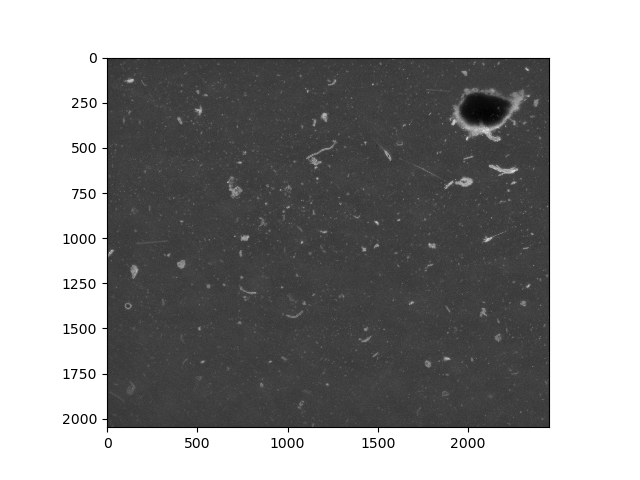

<IPython.core.display.Javascript object>


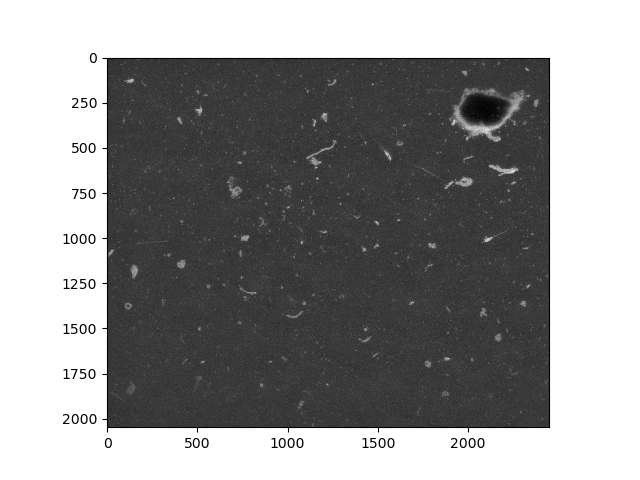

<IPython.core.display.Javascript object>


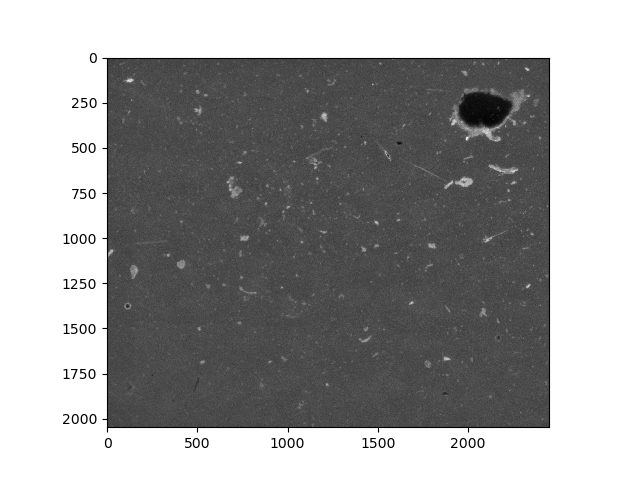

In [6]:
median_grey_value=np.median(photo_blank_grey)
photo_grey_median = filters.median(photo_grey,selem=morphology.disk(200))
photo_grey_median_diff = photo_grey_median - median_grey_value
photo_grey_nobg = photo_grey-photo_grey_median_diff
median_red_value=np.median(photo_blank_red)
median_blue_value=np.median(photo_blank_blue)
photo_red_median = filters.median(photo_red,selem=morphology.disk(200))
photo_blue_median = filters.median(photo_blue,selem=morphology.disk(200))
photo_red_median_diff = photo_red_median - median_red_value
photo_blue_median_diff = photo_blue_median - median_blue_value
photo_red_nobg = photo_red-photo_red_median_diff
photo_blue_nobg = photo_blue-photo_blue_median_diff
plt.figure()
plt.imshow(photo_grey_nobg, cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_grey_nobg.jpg')
plt.figure()
plt.imshow(photo_red_nobg, cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_red_nobg.jpg')
plt.figure()
plt.imshow(photo_blue_nobg, cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_blue_nobg.jpg')


### Amplify contrast mid-tone colors (light brown)
Subtract the red and blue channel images (with background removed) from eachother to amplify the pixels of light brown color

<IPython.core.display.Javascript object>


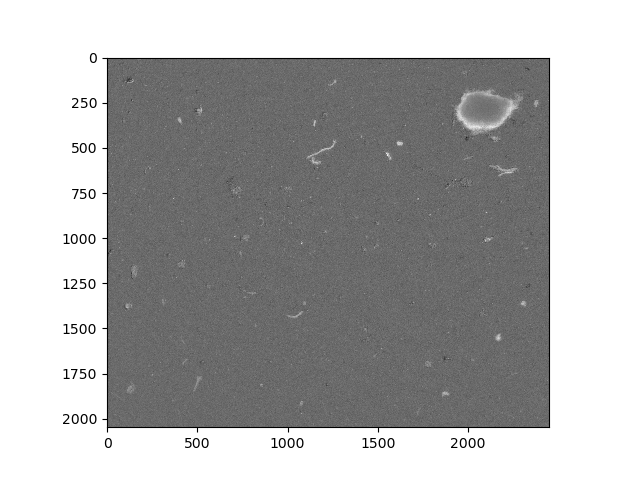

In [7]:
photo_brown_nobg= photo_red_nobg - photo_blue_nobg
plt.figure()
plt.imshow(photo_brown_nobg, cmap=plt.cm.gray)

## Step2: Theshold pixels of potential particles

Now use an intensity level threshold to define pixels of particles.  These are pixel "markers" of particles.  Combine separately thresholded pixels from the greyscale and brown-proxy images.

<IPython.core.display.Javascript object>


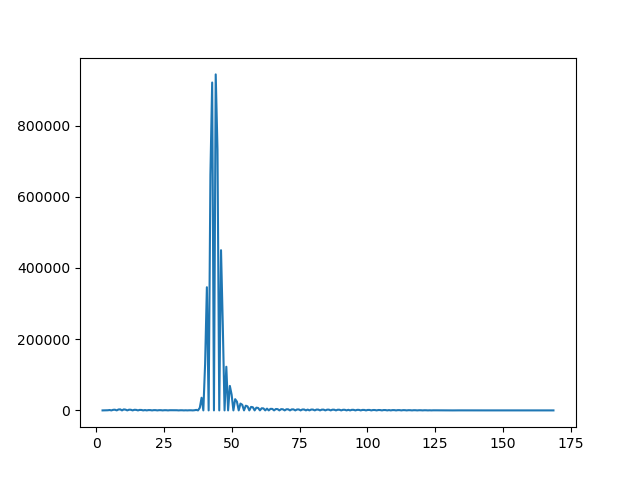

<IPython.core.display.Javascript object>


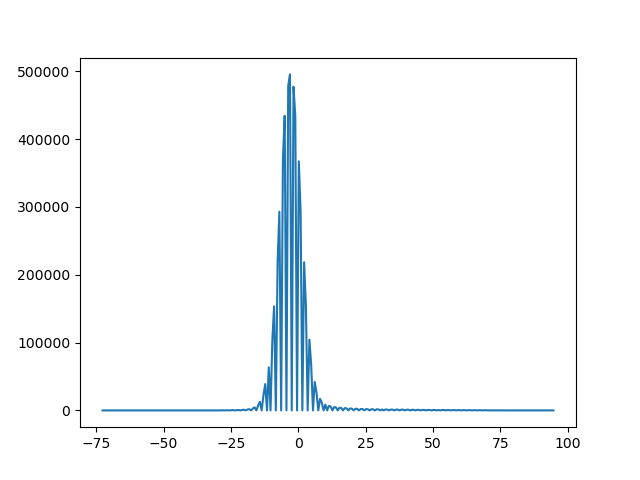

In [8]:
histo = exposure.histogram(photo_grey_nobg)
plt.figure()
plt.plot(histo[1],histo[0])
histo = exposure.histogram(photo_brown_nobg)
plt.figure()
plt.plot(histo[1],histo[0])

### EXPORTS settings:
### 7x:  58,  30,  5
### 20x: 58, 30, 10
### 50x: 56, 33, 9
### 115x: 60, 40, 18

<IPython.core.display.Javascript object>


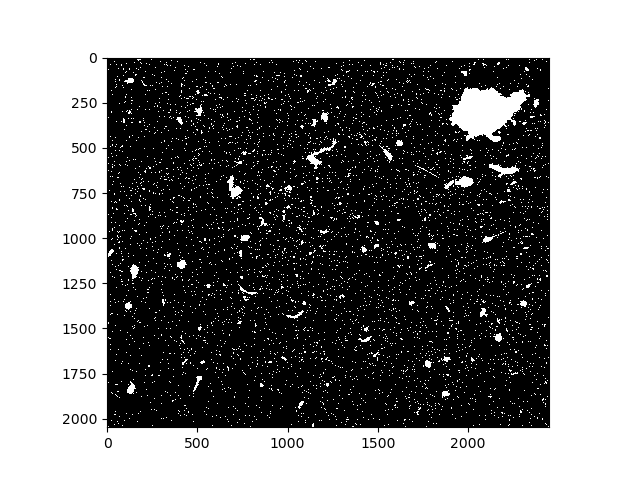

In [10]:
markers = np.zeros_like(photo_grey_nobg)
markers[photo_grey_nobg >=58] = 1   ###Mark very bright pixels in the greyscale image
markers[photo_grey_nobg <= 30] = 1     ###Mark very dark pixels in the greyscale image
markers[photo_brown_nobg >= 5] = 1    ###Mark bright pixels in the brown image
markers_fill = ndi.morphology.binary_fill_holes(markers)
labeled_particles, _ = ndi.label(markers_fill)
plt.figure()
plt.imshow(markers_fill, cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_first_threshold.jpg')


## Step 3: Identify in-focus particle edges

Use a sobel filter to identify sharp changes in pixel intensity.  Mask out the middle of the particle so that only in-focus edges are detected, and not large 3-D particles that are half infocus somewhere in the middle of the particle.  This is also necessary for oblique lighted images, because color changes in the middle of a particle look like sharp edges even if they are out of focus.

<IPython.core.display.Javascript object>


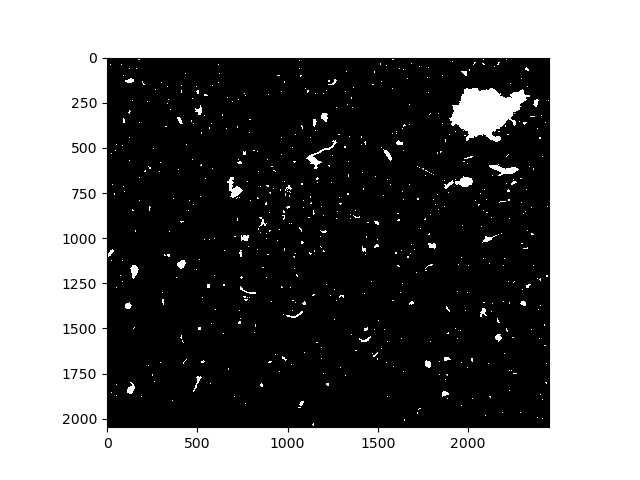

<IPython.core.display.Javascript object>


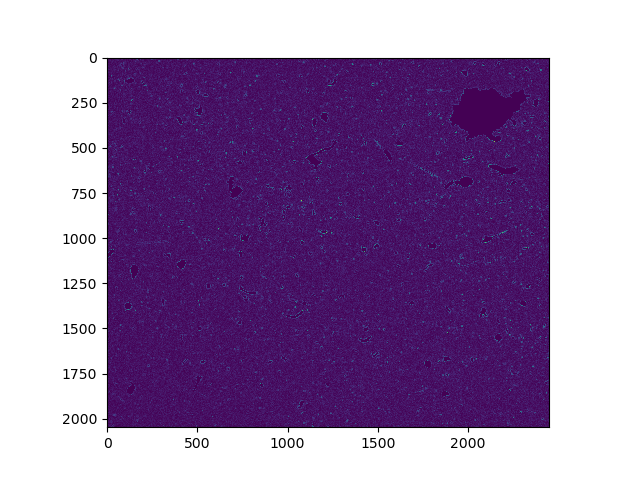

In [11]:
particle_erode = morphology.erosion(markers_fill, selem = morphology.disk(1))
plt.figure()
plt.imshow(particle_erode, cmap=plt.cm.gray)
from skimage.filters import sobel
elevation_map_grey = sobel(photo_grey_nobg)
elevation_map_grey[particle_erode==True]=0
plt.figure()
plt.imshow(elevation_map_grey)



### Use and intensity threshold of the sobel-filtered image to identify pixels belonging to in-focus edges.

<IPython.core.display.Javascript object>


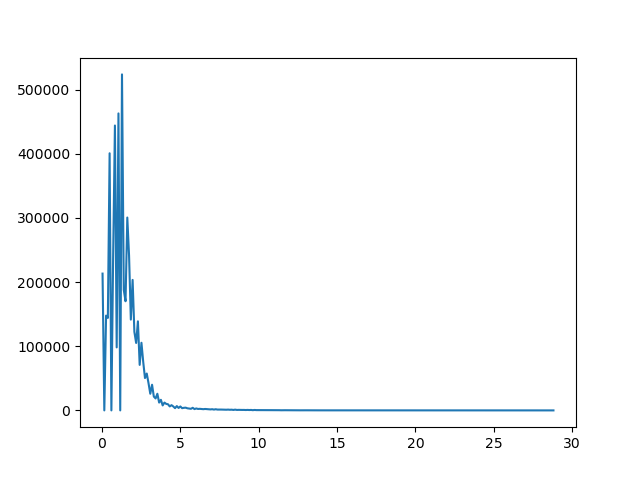

In [12]:
histo = exposure.histogram(elevation_map_grey)
plt.figure()
plt.plot(histo[1],histo[0])

### EXPORTS parameters:
7x: 8

20x: 8

50x:8

115x: 9


<IPython.core.display.Javascript object>


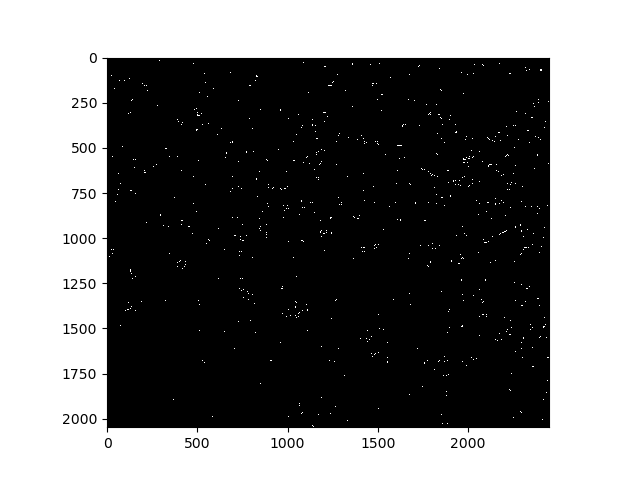

In [14]:
edges = np.zeros_like(photo_grey_nobg)
edges[elevation_map_grey >=8] = 255
labeled_edges , _ = ndi.label(edges)

plt.figure()
plt.imshow(edges,cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_sobel_threshold.jpg')


<IPython.core.display.Javascript object>


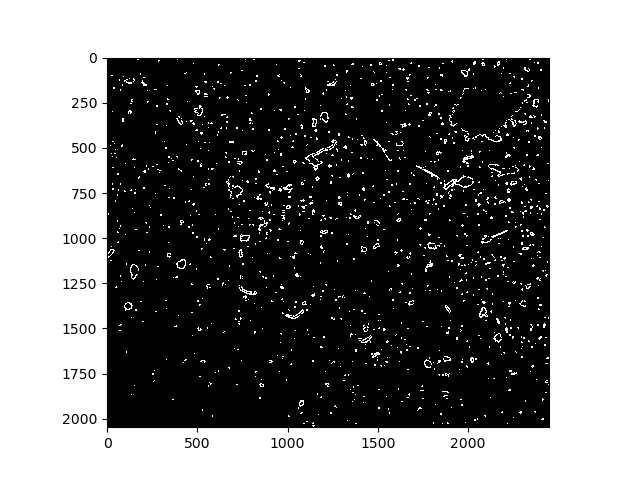

In [21]:
edges_exaggerated = morphology.dilation(edges, selem = morphology.disk(3))
plt.figure()
plt.imshow(edges_exaggerated,cmap=plt.cm.gray)
plt.savefig('/Users/colleen/Desktop/RR53_7x_sobel_threshold_exagerated.jpg')


## Step 4: Match in-focus edges with marker particles

This step loops through coordinates in every labeled edge and checks to see if it overlaps with the the coordinates of a marked particle.  If so, that particle is added to the list of infocus particles.

<IPython.core.display.Javascript object>


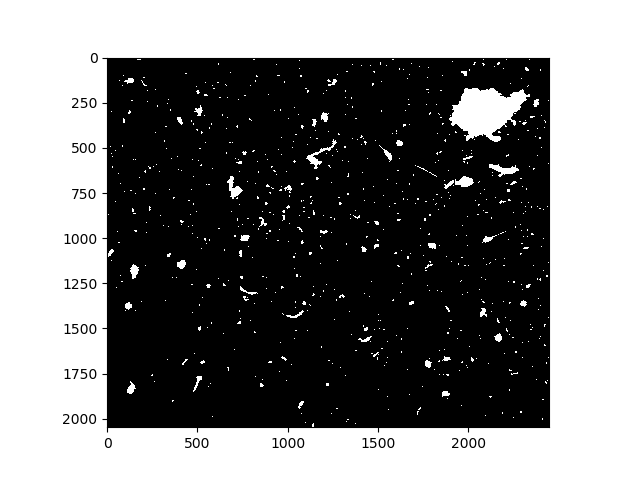

In [12]:
infocus_object_img = np.zeros_like(labeled_particles)
edge_properties = measure.regionprops(labeled_edges)
particle_properties = measure.regionprops(labeled_particles)
infocus_index=[]
for edge in edge_properties:
    e_coords = edge.coords
    
    for x in e_coords:
        infocus = labeled_particles[x[0],x[1]]
        if infocus not in infocus_index:
            infocus_index.append(infocus)
            
for y in infocus_index:
    infocus_object_img[labeled_particles==y] = y
    
masked_image=np.zeros_like(labeled_particles)
masked_image[infocus_object_img>0]=255
plt.figure()
plt.imshow(masked_image, cmap=plt.cm.gray)


## Step 5: Measure and count all the in-focus particles

Measure each particle size and create a list of these measurements.  Can also export images of each individual particle, or apply a logical operator to save the image in a specific folder depending on the measured size.

In [14]:
file = 'RR53_7x_obl_1.tiff'

count = 0
scale = 0.1268 #pixels per micron
scale_area = (scale)**2   #square pixels per square micron
properties = measure.regionprops(infocus_object_img)
particle_area = []
particle_ESD = []
particle_perimeter = []
particle_major_axis= []
particle_minor_axis= []
particle_numberID = []
file_name = []
field = []
fplane = []
brightest_edge = []
particle_coordinates = []
bounding_box = []

for x in properties:
    count = count +1
    px_area=x.area
    um_area = px_area / scale_area
    min_axis = x.minor_axis_length / scale
    maj_axis = x.major_axis_length / scale
    perim = x.perimeter / scale
    ESD = 2*(math.sqrt(um_area/math.pi))
    particle_perimeter.append(perim)
    particle_major_axis.append(maj_axis)
    particle_minor_axis.append(min_axis)
    particle_area.append(um_area)
    particle_ESD.append(ESD)
    particle = photo[x.bbox[0]:x.bbox[2],x.bbox[1]:x.bbox[3]]
    particle_numberID.append(count)
    file_name.append(file)
    name_words = file.split('_')
    focalplane = name_words[len(name_words)-1]
    if focalplane[0:2].isdigit():
        fov = focalplane[0:2]
        plane = focalplane[2]
    else:
        fov = focalplane[0]
        plane = focalplane[1]
    field.append(fov)
    fplane.append(plane)
    edge_area=elevation_map_grey[x.bbox[0]:x.bbox[2],x.bbox[1]:x.bbox[3]]
    max_edge_intensity = np.max(edge_area)
    brightest_edge.append(max_edge_intensity)
    particle_coordinates.append(np.ndarray.tolist(x.coords))
    bounding_box.append(str([x.bbox[0],x.bbox[2],x.bbox[1],x.bbox[3]]))


In [15]:
import pandas as pd
data = pd.DataFrame(np.stack((particle_numberID, particle_area, particle_ESD, particle_minor_axis, particle_major_axis, particle_perimeter, file_name, field, fplane, brightest_edge, particle_coordinates, bounding_box),-1),columns=['Number','Area','ESD','minor_length','major_length','perimeter','file_name', 'fov','focal_plane','edge_intensity','particle_coordinates','bounding_box'])
data

,Number,Area,ESD,minor_length,major_length,perimeter,file_name,fov,focal_plane,edge_intensity,particle_coordinates,bounding_box
0,1,13185.5,129.57,112.638,158.888,520.321,RR53_7x_obl_1.tiff,1,.,10.335,"[[1, 172], [1, 173], [2, 169], [2, 170], [2, 1...","[1, 18, 166, 188]"
1,2,5908.61,86.7356,75.3538,111.091,347.331,RR53_7x_obl_1.tiff,1,.,9.36082,"[[2, 397], [2, 398], [2, 399], [2, 400], [3, 3...","[2, 14, 389, 404]"
2,3,559.763,26.6967,23.1023,36.5198,67.9915,RR53_7x_obl_1.tiff,1,.,9.89002,"[[2, 2224], [2, 2225], [2, 2226], [3, 2224], [...","[2, 6, 2224, 2227]"
3,4,684.154,29.5143,23.5421,39.8004,68.2717,RR53_7x_obl_1.tiff,1,.,9.01388,"[[3, 184], [4, 183], [4, 184], [4, 185], [4, 1...","[3, 7, 183, 188]"
4,5,1803.68,47.922,41.5928,67.7052,164.542,RR53_7x_obl_1.tiff,1,.,11.7527,"[[8, 812], [8, 813], [8, 814], [8, 815], [9, 8...","[8, 16, 811, 817]"
5,6,435.371,23.5442,13.98,39.3843,48.9519,RR53_7x_obl_1.tiff,1,.,13.8067,"[[8, 1160], [8, 1161], [8, 1162], [8, 1163], [...","[8, 10, 1160, 1165]"
6,7,4229.32,73.3821,71.4246,79.9423,271.173,RR53_7x_obl_1.tiff,1,.,13.4001,"[[8, 1586], [8, 1587], [9, 1582], [9, 1583], [...","[8, 18, 1579, 1589]"
7,8,62.1959,8.89889,0,0,0,RR53_7x_obl_1.tiff,1,.,8.00391,"[[9, 1165]]","[9, 10, 1165, 1166]"
8,9,1554.9,44.4944,32.8727,66.4028,155.583,RR53_7x_obl_1.tiff,1,.,9.98123,"[[9, 2083], [10, 2081], [10, 2082], [10, 2083]...","[9, 16, 2081, 2088]"
9,10,1928.07,49.5469,44.5168,66.279,164.823,RR53_7x_obl_1.tiff,1,.,8.31039,"[[10, 2212], [10, 2213], [11, 2212], [11, 2213...","[10, 16, 2209, 2218]"
